In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

### Loading training dataset 

Dataset reference: https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic

In [2]:
# Dataset path
data_path='/kaggle/input/comic-faces-paired-synthetic/face2comics_v1.0.0_by_Sxela/face2comics_v1.0.0_by_Sxela/'

In [3]:
# Sorting the filenames in both directories
input_filenames = sorted(os.listdir(data_path+'face'))
target_filenames = sorted(os.listdir(data_path+'comics'))
if len(input_filenames) != len(target_filenames):
    print("Number of input and target images do not match")
# Iterate over each pair of filenames and check if they match
for input_filename, target_filename in zip(input_filenames, target_filenames):
    # Extract the file name without extension
    input_name = os.path.splitext(input_filename)[0]
    target_name = os.path.splitext(target_filename)[0]

    # Check if the filenames match
    if input_name != target_name:
        print("Input and target image names do not match")

In [ ]:
# Define lists to store input and target images
train_input_images = []
train_target_images = []
# Path to the folder containing input and target folders
i=0
# Iterate over each pair of filenames
for input_filename, target_filename in zip(input_filenames, target_filenames):
    # Load input and target images
    input_img_path = os.path.join(data_path, 'face', input_filename)
    target_img_path = os.path.join(data_path, 'comics', target_filename)
    input_img = cv2.imread(input_img_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    target_img = cv2.imread(target_img_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    if input_img is None or target_img is None:
        print("Error loading images")
    # Resizing images to 256x256x3
    input_img = cv2.resize(input_img, (256, 256))
    target_img = cv2.resize(target_img, (256, 256))

    # Preprocess images
    # Normalize pixel values to the range [0, 1]
    input_img = input_img / 255.0
    target_img = target_img / 255.0

    # Append images to lists
    train_input_images.append(input_img)
    train_target_images.append(target_img)
    
    # Print to check progress
    if i%50==0:
        print(i)
    # Due to memory limits I used only a fraction of the images
    if i>3000:
        break
    
    i=i+1
# Convert lists to numpy arrays
train_input_images = np.array(train_input_images)
train_target_images = np.array(train_target_images)
print("Shape of train input images:", train_input_images.shape)
print("Shape of train target images:", train_target_images.shape)

### Building the model

Check how to use the pix2pix image-to-image model here: https://www.tensorflow.org/tutorials/generative/pix2pix

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
    return total_gen_loss, gan_loss, l1_loss

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [ ]:
# Defining the generator, discriminator, optimizers and loss function
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
OUTPUT_CHANNELS=3
LAMBDA = 100
generator = Generator()
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
discriminator = Discriminator()

### Training the model

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/generative/pix2pix
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [ ]:
def fit(train_input_images, train_target_images, steps, batch_size=32, checkpoint=None, checkpoint_prefix=None):
    start = time.time()
    for step in range(steps):
        for batch_start in range(0, len(train_input_images), batch_size):
            batch_input = train_input_images[batch_start:batch_start+batch_size]
            batch_target = train_target_images[batch_start:batch_start+batch_size]
            
            train_step(tf.convert_to_tensor(batch_input, dtype=tf.float32), 
                       tf.convert_to_tensor(batch_target, dtype=tf.float32), 
                       step)
        
        # Training step
        print(step)
        
        # Saving the models every 30 epochs
        if (step + 1) % 30 == 0:
            generator.save('generator_model.h5')
            discriminator.save('discriminator_model.h5')
        
    print("\nTotal time:", time.time() - start, "seconds")
    generator.save('generator_model.h5')
    discriminator.save('discriminator_model.h5')

In [ ]:
# Training
fit(train_input_images, train_target_images, steps=1000)

### Visualizing the model results

Generating comic images using faces not seen in model training

In [4]:
# Modified the function from https://www.tensorflow.org/tutorials/generative/pix2pix
def generate_images(model,image_name,test_input,tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image '+image_name, 'Ground Truth '+image_name, 'Predicted Image '+image_name]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

In [5]:
generator=load_model('/kaggle/input/pipx2pixmodel/tensorflow2/pip2pixmodel/1/generator_model.h5')

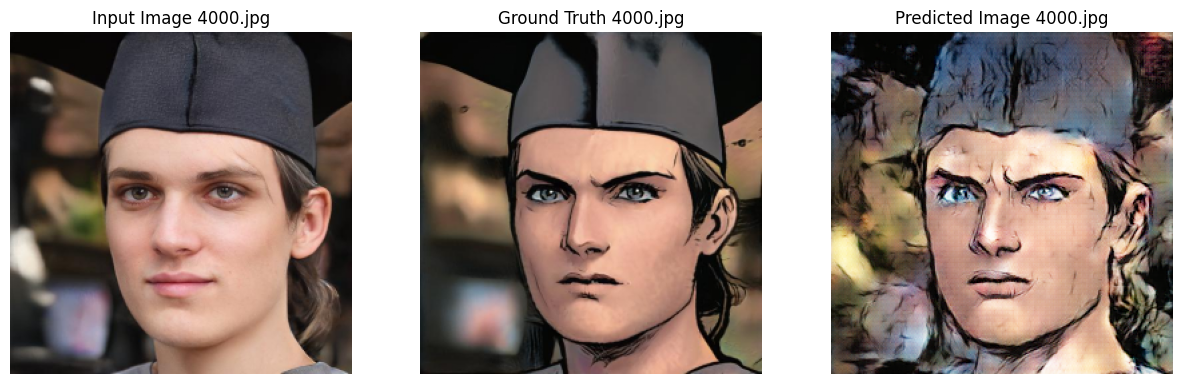

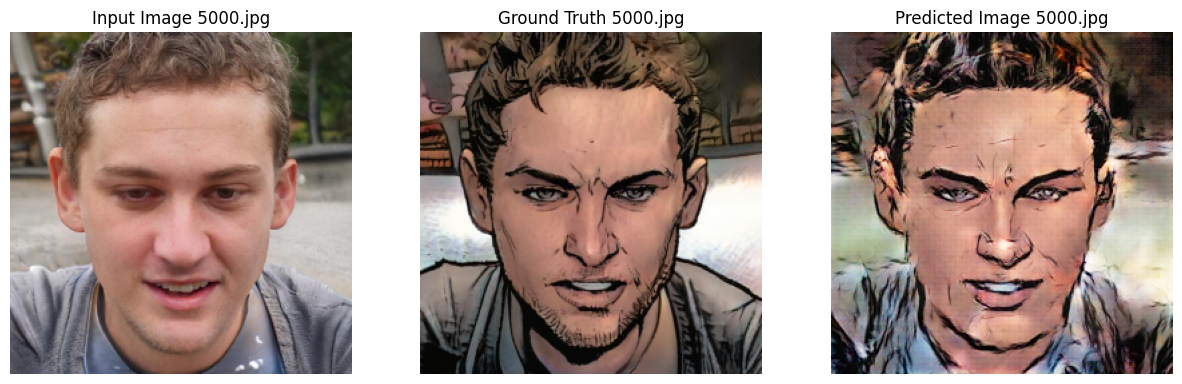

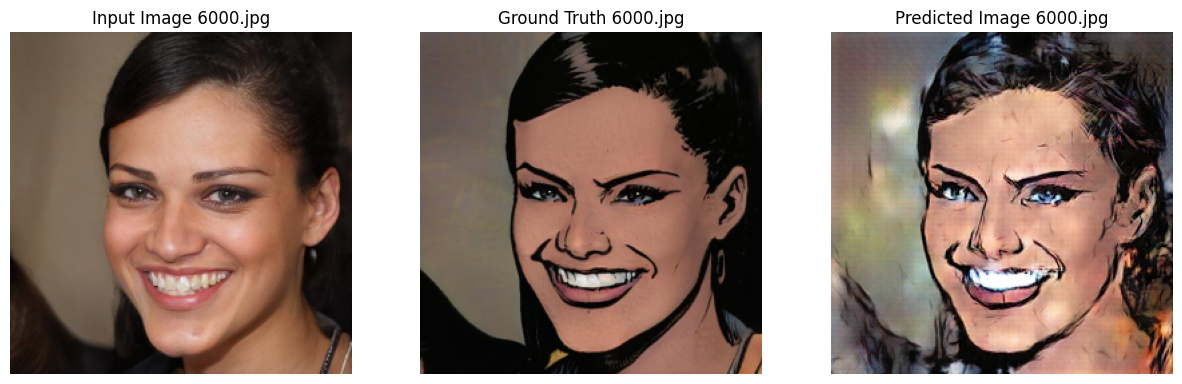

In [6]:
for image_name in ['4000.jpg','5000.jpg','6000.jpg']:
    input_img_path = os.path.join(data_path, 'face', image_name)
    target_img_path = os.path.join(data_path, 'comics', image_name)
    input_img = cv2.imread(input_img_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    target_img = cv2.imread(target_img_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    input_img = cv2.resize(input_img, (256, 256))
    target_img = cv2.resize(target_img, (256, 256))
    input_img = input_img / 255.0
    target_img = target_img / 255.0
    generate_images(generator,image_name,tf.expand_dims(input_img.astype(np.float32),0), tf.expand_dims(target_img.astype(np.float32),0))